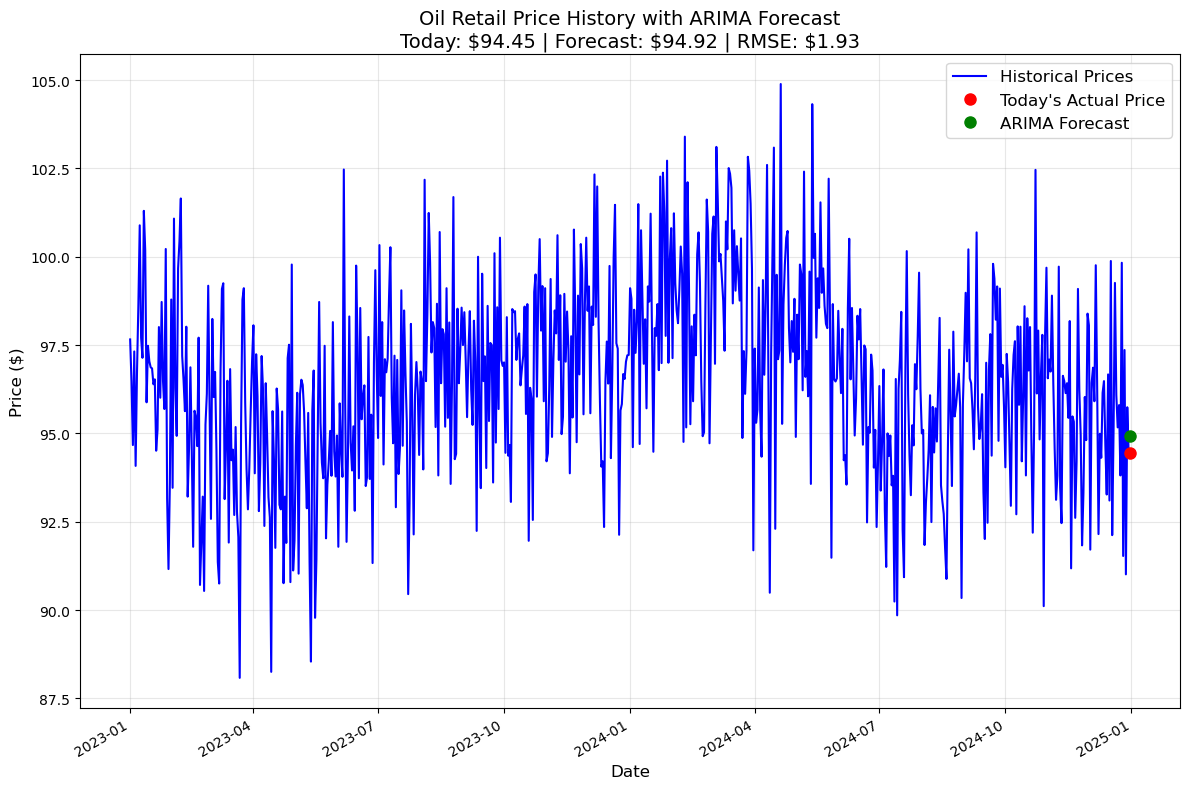

Today's actual price: $94.45
ARIMA forecast: $94.92
Difference: $0.47
Model RMSE (30-day validation): $1.93


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import json
import warnings
warnings.filterwarnings('ignore')

# Load the historical data
df = pd.read_csv('C:/Python Data/oil_retail_history.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# Load today's data
with open('C:/Python Data/today_example.json', 'r') as f:
    today_data = json.load(f)

# Convert today's data to a DataFrame row
today_df = pd.DataFrame([{
    'date': pd.to_datetime(today_data['date']),
    'price': today_data['price'],
    'cost': today_data['cost'],
    'comp1_price': today_data['comp1_price'],
    'comp2_price': today_data['comp2_price'],
    'comp3_price': today_data['comp3_price'],
    'volume': np.nan  # Not provided in today's data
}])

# Combine historical data with today's data
full_df = pd.concat([df, today_df], ignore_index=True)
full_df = full_df.sort_values('date').reset_index(drop=True)

# Prepare time series data
ts_data = full_df.set_index('date')['price']

# Split data into train and test (using today's data as test)
train = ts_data[:-1]  # All data except the last point (today)
test = ts_data[-1:]   # Today's data

# Fit ARIMA model

model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Make prediction
forecast = model_fit.forecast(steps=1)
forecast_value = forecast[0]

# Calculate RMSE for model evaluation (using last 30 days as validation)
validation_data = ts_data[-31:-1]  # Last 30 days before today
model_val = ARIMA(validation_data, order=(2, 1, 2))
model_val_fit = model_val.fit()
val_forecast = model_val_fit.forecast(steps=1)
val_actual = ts_data[-1:].values[0]
rmse = np.sqrt(mean_squared_error([val_actual], [val_forecast[0]]))

# Create visualization
plt.figure(figsize=(12, 8))

# Plot historical data
plt.plot(ts_data.index[:-1], ts_data.values[:-1], 'b-', label='Historical Prices', linewidth=1.5)

# Plot today's actual price
plt.plot(ts_data.index[-1:], ts_data.values[-1:], 'ro', markersize=8, label="Today's Actual Price")

# Plot forecast
plt.plot(ts_data.index[-1:], forecast_value, 'go', markersize=8, label='ARIMA Forecast')

# Add labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Oil Retail Price History with ARIMA Forecast\nToday: ${:.2f} | Forecast: ${:.2f} | RMSE: ${:.2f}'.format(
    ts_data.values[-1], forecast_value, rmse), fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Print summary
print(f"Today's actual price: ${ts_data.values[-1]:.2f}")
print(f"ARIMA forecast: ${forecast_value:.2f}")
print(f"Difference: ${abs(ts_data.values[-1] - forecast_value):.2f}")
print(f"Model RMSE (30-day validation): ${rmse:.2f}")